# 라이브러리 임포트

In [1]:
# basic
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
import optuna
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import random
import os

SEED = 22
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
df = pd.read_csv('../datasets/business5.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19534 entries, 0 to 19533
Data columns (total 93 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   business_id          19534 non-null  object 
 1   name                 19534 non-null  object 
 2   address              19467 non-null  object 
 3   city                 19534 non-null  object 
 4   state                19534 non-null  object 
 5   postal_code          19532 non-null  float64
 6   latitude             19534 non-null  float64
 7   longitude            19534 non-null  float64
 8   stars                19534 non-null  float64
 9   review_count         19534 non-null  int64  
 10  is_open              19534 non-null  int64  
 11  attributes           19527 non-null  object 
 12  categories           19534 non-null  object 
 13  hours                18432 non-null  object 
 14  store_status         19534 non-null  object 
 15  c_nightlife          19534 non-null 

### STEP 1 : 컬럼 셀렉

In [5]:

exclude_cols = [

    # basic restaurant information
    'business_id', 'name', 'attributes', 'categories', 'hours',

    # location information
    'address', 'city', 'postal_code', 'latitude', 'longitude',

    # business hours information
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',

    # cols that used to create stability_score
    'stars', 'stars_std', 'review_count'

            ]

df = df.drop(columns=exclude_cols)

### STEP 2 : 데이터 타입 변경

In [6]:
# -------------------------
# 2. object -> int
# -------------------------


# 변환할 컬럼 리스트
bool_cols = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']

# 문자열을 0/1로 변환하는 함수
def str_to_int_bool(x):
    if pd.isna(x):
        return np.nan   # 결측값은 그대로 유지 (원하면 0으로 바꿔도 됨)
    elif str(x).strip().lower() == 'true':
        return 1
    elif str(x).strip().lower() == 'false':
        return 0
    else:
        return np.nan

# 각 컬럼에 적용
for col in bool_cols:
    df[col] = df[col].apply(str_to_int_bool).astype('Int64')  # pandas nullable int형


In [7]:
# -------------------------
# 2. 노이즈레벨 순서형 맵핑
# -------------------------

# quiet < average < loud < very_loud

noise_mapping = {
    'quiet': 0,
    'average': 1,
    'loud': 2,
    'very_loud': 3
}

df['a_noise_level'] = df['a_noise_level'].map(noise_mapping)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19534 entries, 0 to 19533
Data columns (total 73 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                19534 non-null  object 
 1   is_open              19534 non-null  int64  
 2   store_status         19534 non-null  object 
 3   c_nightlife          19534 non-null  int64  
 4   c_cafes              19534 non-null  int64  
 5   c_brunch             19534 non-null  int64  
 6   c_sandwich           19534 non-null  int64  
 7   c_american_trad      19534 non-null  int64  
 8   c_american_new       19534 non-null  int64  
 9   c_italian            19534 non-null  int64  
 10  c_burgers            19534 non-null  int64  
 11  c_mexican            19534 non-null  int64  
 12  c_seafood            19534 non-null  int64  
 13  c_fastfood           19534 non-null  int64  
 14  c_asian_fusion       19534 non-null  int64  
 15  c_bakeries           19534 non-null 

### STEP 3: 결측치 처리

In [9]:
# -------------------------
# 1. a_outdoor_seating ~ a_happy_hour
# -------------------------

# 결측값 = 0(해당사항 없음) 으로

cols_bool = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']
df[cols_bool] = df[cols_bool].fillna(0).astype(int)

In [10]:
# -------------------------
# 2. a_alcohol
# -------------------------

# c_nightlife 컬럼 값에 따라 다르게

df['a_alcohol'] = np.where(
    df['a_alcohol'].isna(),                        # ① 결측치인 행만 선택
    np.where(df['c_nightlife'] == 1, 'full_bar', 'none'),  # ② nightlife면 full_bar, 아니면 none
    df['a_alcohol']                                 # ③ 기존값 유지
)

In [11]:
# -------------------------
# 3. a_ambience
# -------------------------

df['a_ambience'] = df['a_ambience'].fillna('unknown')

### STEP 4: 이상치 제거

In [12]:
# total hours = 0인 케이스 삭제

# 제거 전 전체 개수 확인
before_count = len(df)

# total_weekly_hours == 0 제거
df = df[df['total_weekly_hours'] > 0].copy()

# 제거 후 개수 및 비율 확인
after_count = len(df)
removed = before_count - after_count
print(f"총 {removed}개 레코드 제거됨 ({removed / before_count:.2%})")


총 1480개 레코드 제거됨 (7.58%)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18054 entries, 0 to 19533
Data columns (total 73 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                18054 non-null  object 
 1   is_open              18054 non-null  int64  
 2   store_status         18054 non-null  object 
 3   c_nightlife          18054 non-null  int64  
 4   c_cafes              18054 non-null  int64  
 5   c_brunch             18054 non-null  int64  
 6   c_sandwich           18054 non-null  int64  
 7   c_american_trad      18054 non-null  int64  
 8   c_american_new       18054 non-null  int64  
 9   c_italian            18054 non-null  int64  
 10  c_burgers            18054 non-null  int64  
 11  c_mexican            18054 non-null  int64  
 12  c_seafood            18054 non-null  int64  
 13  c_fastfood           18054 non-null  int64  
 14  c_asian_fusion       18054 non-null  int64  
 15  c_bakeries           18054 non-null  int6

### STEP 5 : 로그 변환

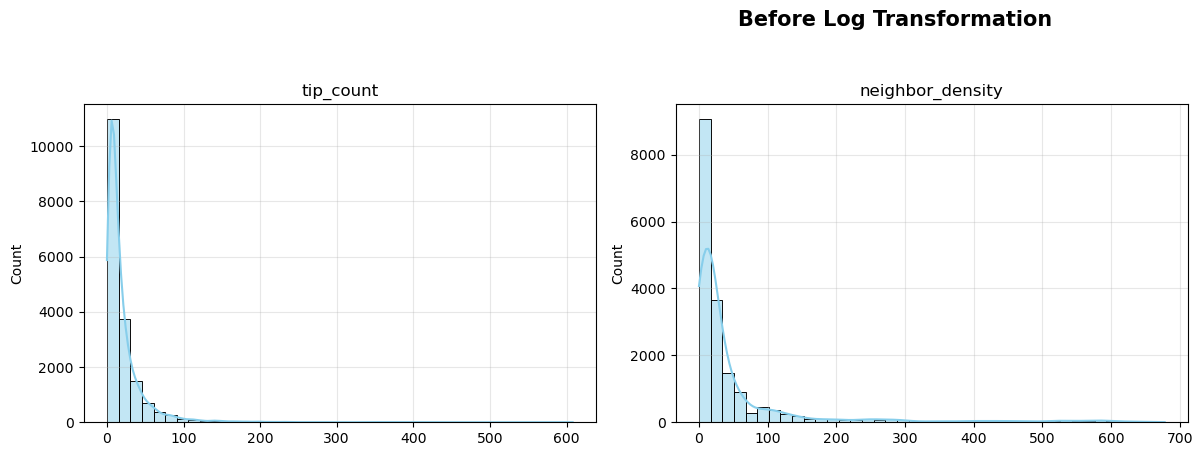

In [14]:
# 로그 변환 대상 컬럼
cols_to_log = [
    'tip_count',
    'neighbor_density'
]

# 시각화 (변환 전)
plt.figure(figsize=(18, 8))
plt.suptitle("Before Log Transformation", fontsize=15, fontweight="bold")

for i, col in enumerate(cols_to_log, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:

# 0 이하 값 방지를 위해 clip 사용
for col in cols_to_log:
    df[col] = np.log1p(df[col].clip(lower=0))


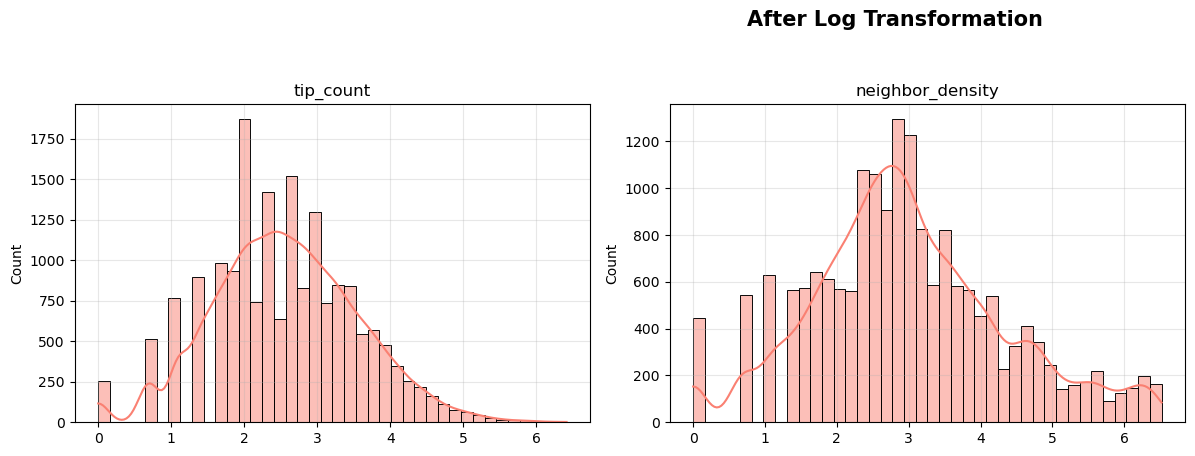

In [16]:
# 시각화 (변환 후)
plt.figure(figsize=(18, 8))
plt.suptitle("After Log Transformation", fontsize=15, fontweight="bold")

for i, col in enumerate(cols_to_log, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=40, kde=True, color='salmon')
    plt.title(f'{col}')
    plt.xlabel('')
    plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18054 entries, 0 to 19533
Data columns (total 73 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                18054 non-null  object 
 1   is_open              18054 non-null  int64  
 2   store_status         18054 non-null  object 
 3   c_nightlife          18054 non-null  int64  
 4   c_cafes              18054 non-null  int64  
 5   c_brunch             18054 non-null  int64  
 6   c_sandwich           18054 non-null  int64  
 7   c_american_trad      18054 non-null  int64  
 8   c_american_new       18054 non-null  int64  
 9   c_italian            18054 non-null  int64  
 10  c_burgers            18054 non-null  int64  
 11  c_mexican            18054 non-null  int64  
 12  c_seafood            18054 non-null  int64  
 13  c_fastfood           18054 non-null  int64  
 14  c_asian_fusion       18054 non-null  int64  
 15  c_bakeries           18054 non-null  int6

In [18]:
df.head()

,state,is_open,store_status,c_nightlife,c_cafes,c_brunch,c_sandwich,c_american_trad,c_american_new,c_italian,...,tip_count,has_tip,neighbor_density,neighbor_similarity,neighbor_avg_stars,avg_review_length,avg_sentiment,stability_score,loyalty_score,reliability_score
0,PA,1,open_old,0,1,0,0,0,0,0,...,2.397895,1,5.840642,0.218659,3.689504,104.620690,0.695723,57.431377,63.601512,64.011654
1,IN,1,open_old,0,0,1,0,1,0,0,...,1.791759,1,2.995732,0.473684,3.368421,79.137931,0.170748,26.924359,52.587241,48.460135
2,FL,0,close_external,0,0,0,1,0,0,1,...,2.944439,1,2.197225,0.500000,3.562500,77.849057,0.762607,60.376124,65.179057,43.832936
3,PA,1,open_old,1,0,0,0,0,0,0,...,2.890372,1,5.010635,0.523490,3.687919,118.448000,0.803010,65.223712,63.350000,41.730439
4,PA,1,open_old,0,0,0,0,0,0,0,...,3.044522,1,6.126869,0.159737,3.749453,79.451923,0.855654,74.454651,62.813013,43.424521


# ML 시작!!

In [19]:
# -------------------------
# 1. Split data into train and test sets
# -------------------------

X = df.drop("stability_score", axis=1)
y = df["stability_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [20]:
# -------------------------
# 2. Impute missing values
# -------------------------

# --- (1) a_price_range ---

# 1️⃣ 카테고리 컬럼 리스트
cat_cols = [
    'c_nightlife', 'c_cafes', 'c_brunch', 'c_sandwich', 'c_american_trad', 'c_american_new',
    'c_italian', 'c_burgers', 'c_mexican', 'c_seafood', 'c_fastfood',
    'c_asian_fusion', 'c_bakeries', 'c_dietary', 'c_other'
]

# 2️⃣ train 데이터 기준으로 각 카테고리별 중앙값 계산
cat_medians_train = {
    c: X_train.loc[X_train[c] == 1, 'a_price_range'].median()
    for c in cat_cols
}

# train 전체 중앙값 (fallback용)
overall_median = X_train['a_price_range'].median()

# 3️⃣ 결측치 채우기 함수 정의
def fill_price(row, cat_medians, overall_median):
    if pd.notna(row['a_price_range']):
        return row['a_price_range']
    
    cats = [c for c in cat_cols if row[c] == 1]
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]
    
    if len(vals) == 0:
        val = overall_median
    elif len(vals) == 1:
        val = vals[0]
    else:
        val = np.mean(vals)
    
    return round(val)

# 4️⃣ train / test 각각에 적용
X_train['a_price_range'] = X_train.apply(
    fill_price, axis=1, args=(cat_medians_train, overall_median)
).astype(int)

X_test['a_price_range'] = X_test.apply(
    fill_price, axis=1, args=(cat_medians_train, overall_median)  # train의 통계값 사용
).astype(int)

In [21]:
# --- (2) a_noise_level ---

# 1️⃣ train 데이터 기준으로 각 카테고리별 중앙값 계산
cat_medians_train = {
    c: X_train.loc[X_train[c] == 1, 'a_noise_level'].median()
    for c in cat_cols
}

# train 전체 중앙값 (fallback용)
overall_median = X_train['a_noise_level'].median()

# 2️⃣ 결측치 채우기 함수 정의
def fill_noise(row, cat_medians, overall_median):
    if pd.notna(row['a_noise_level']):
        return row['a_noise_level']
    
    cats = [c for c in cat_cols if row[c] == 1]
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]
    
    if len(vals) == 0:
        val = overall_median
    elif len(vals) == 1:
        val = vals[0]
    else:
        val = np.mean(vals)
    
    return round(val)

# 3️⃣ train / test 각각에 적용
X_train['a_noise_level'] = X_train.apply(
    fill_noise, axis=1, args=(cat_medians_train, overall_median)
).astype(int)

X_test['a_noise_level'] = X_test.apply(
    fill_noise, axis=1, args=(cat_medians_train, overall_median)  # train의 통계값만 사용
).astype(int)


In [22]:
# --- (3) neighbor_avg_stars ---

# 훈련 세트에서 평균값 계산
mean_neighbor_stars = X_train['neighbor_avg_stars'].mean()


# 동일 평균으로 결측치 대체
X_train['neighbor_avg_stars'] = X_train['neighbor_avg_stars'].fillna(mean_neighbor_stars)
X_test['neighbor_avg_stars'] = X_test['neighbor_avg_stars'].fillna(mean_neighbor_stars)


In [23]:
# -----------------------------
# 3. Target Encoding
# -----------------------------

import category_encoders as ce

# categorical columns only
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

encoder = ce.CatBoostEncoder(cols=cat_cols)
X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test)

In [24]:
# -----------------------------
# 4. Scaling (numeric only)
# -----------------------------

num_cols = X_train_enc.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X_train_enc[num_cols] = scaler.fit_transform(X_train_enc[num_cols])
X_test_enc[num_cols] = scaler.transform(X_test_enc[num_cols])

In [25]:
# -----------------------------
# 3️⃣ Define models
# -----------------------------
SEED = 22
models = {
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=SEED),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(random_state=SEED, n_jobs=1),
    "AdaBoost": AdaBoostRegressor(random_state=SEED),
    "Gradient Boost": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED, verbosity=0, n_jobs=1, deterministic=True),
    "LightGBM": LGBMRegressor(random_state=SEED, n_jobs=1, deterministic=True),
    "CatBoost": CatBoostRegressor(random_state=SEED, verbose=0, thread_count=1)
}

# -----------------------------
# 4️⃣ Evaluate baseline performance
# -----------------------------
results = []
for name, model in models.items():
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2})

# -----------------------------
# 5️⃣ Results DataFrame
# -----------------------------
results_df = (
    pd.DataFrame(results)
    .sort_values(by="MAE", ascending=True)
    .reset_index(drop=True)
)

display(results_df.style.format({"RMSE": "{:,.2f}", "MAE": "{:,.2f}", "R²": "{:.4f}"}))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3411
[LightGBM] [Info] Number of data points in the train set: 14443, number of used features: 72
[LightGBM] [Info] Start training from score 43.590437


,Model,RMSE,MAE,R²
0,CatBoost,11.09,9.06,0.7039
1,LightGBM,11.07,9.08,0.7053
2,Gradient Boost,11.15,9.14,0.7011
3,Random Forest,11.35,9.37,0.6901
4,XGBoost,11.98,9.66,0.6547
5,SVM,12.57,9.95,0.6197
6,AdaBoost,11.93,10.13,0.6574
7,Decision Tree,16.25,12.58,0.3643
8,KNN,15.81,12.67,0.3983


In [30]:
# -------------------------
# 6. Hyperparameter tuning
# -------------------------

# Define an objective function
def objective_cat(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "loss_function": "MAE",
        "verbose": 0,
        "random_state": 22
    }

    # Define model
    model = CatBoostRegressor(**params)

    # Fit model
    model.fit(X_train_enc, y_train, eval_set=(X_test_enc, y_test), verbose=0)

    # Predict
    y_pred = model.predict(X_test_enc)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Run optimization
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=100, show_progress_bar=True)

# Show best results
print("Best MAE:", study_cat.best_value)
print("Best Parameters:", study_cat.best_params)

# Train final model
best_params_cat = study_cat.best_params
best_params_cat["loss_function"] = "MAE"
best_cat = CatBoostRegressor(**best_params_cat)
best_cat.fit(X_train_enc, y_train)

# Predict and evaluate on test data
y_pred = best_cat.predict(X_test_enc)

print("\n===== CatBoost (Optimized) =====")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

[I 2025-11-10 23:37:05,015] A new study created in memory with name: no-name-f4606ef7-247e-4d5b-8c5c-4730189d4df5


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-10 23:37:08,116] Trial 0 finished with value: 8.706522857878776 and parameters: {'iterations': 933, 'depth': 4, 'learning_rate': 0.05124271075945884, 'l2_leaf_reg': 5.786210056585798, 'bagging_temperature': 0.3358509553427048, 'random_strength': 0.20730105250399647, 'border_count': 114, 'subsample': 0.9219220682628583}. Best is trial 0 with value: 8.706522857878776.
[I 2025-11-10 23:37:15,676] Trial 1 finished with value: 8.816284146040363 and parameters: {'iterations': 993, 'depth': 8, 'learning_rate': 0.03668496121571702, 'l2_leaf_reg': 1.606612862555324, 'bagging_temperature': 0.8438770096889551, 'random_strength': 0.9389150406611827, 'border_count': 51, 'subsample': 0.844749077601496}. Best is trial 0 with value: 8.706522857878776.
[I 2025-11-10 23:37:17,767] Trial 2 finished with value: 8.684784313468203 and parameters: {'iterations': 811, 'depth': 4, 'learning_rate': 0.08010274612929492, 'l2_leaf_reg': 7.047992296878405, 'bagging_temperature': 0.2637597197704892, 'rand

In [26]:
# -------------------------
# 7. Set base models with best params
# -------------------------

final_cat = CatBoostRegressor(
    iterations = 862, 
    depth = 5, 
    learning_rate = 0.058689835482522414, 
    l2_leaf_reg = 1.9807690222877246, 
    bagging_temperature = 0.8265430367130593, 
    random_strength = 0.8658756037983393, 
    border_count = 249, 
    subsample = 0.8625750595761923,
    loss_function = "MAE"
)

# Train final cat model
final_cat.fit(X_train_enc, y_train)

# Predict and evaluate on test data
y_pred = final_cat.predict(X_test_enc)

print("\n===== CatBoost (Optimized) =====")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

0:	learn: 16.3206629	total: 4.37ms	remaining: 3.76s
1:	learn: 15.7549524	total: 7.98ms	remaining: 3.43s
2:	learn: 15.1850359	total: 11.4ms	remaining: 3.25s
3:	learn: 14.7124992	total: 15.4ms	remaining: 3.31s
4:	learn: 14.2089896	total: 19.1ms	remaining: 3.27s
5:	learn: 13.7699630	total: 22.4ms	remaining: 3.19s
6:	learn: 13.3856424	total: 25.7ms	remaining: 3.14s
7:	learn: 13.0327767	total: 29.9ms	remaining: 3.19s
8:	learn: 12.7113949	total: 33.4ms	remaining: 3.17s
9:	learn: 12.4411938	total: 36.8ms	remaining: 3.13s
10:	learn: 12.1778491	total: 40ms	remaining: 3.1s
11:	learn: 11.9215766	total: 43.3ms	remaining: 3.07s
12:	learn: 11.6857183	total: 47ms	remaining: 3.07s
13:	learn: 11.4932786	total: 51.8ms	remaining: 3.14s
14:	learn: 11.3264791	total: 55.4ms	remaining: 3.13s
15:	learn: 11.1691872	total: 58.6ms	remaining: 3.1s
16:	learn: 11.0021005	total: 62.3ms	remaining: 3.1s
17:	learn: 10.8754809	total: 66.7ms	remaining: 3.13s
18:	learn: 10.7630076	total: 70.1ms	remaining: 3.11s
19:	learn:

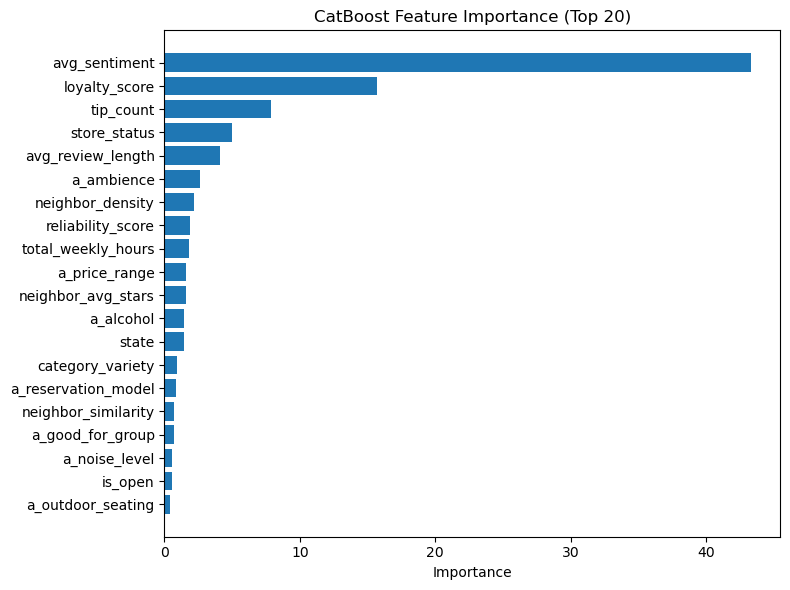

In [42]:
# 피쳐 임포턴스 (cat)

# Get feature importance values
importances = final_cat.get_feature_importance()
features = X_train.columns  # use the same feature order as training data

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"].head(20)[::-1], importance_df["Importance"].head(20)[::-1])
plt.title("CatBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_21780\1580502695.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_enc, max_display=15)


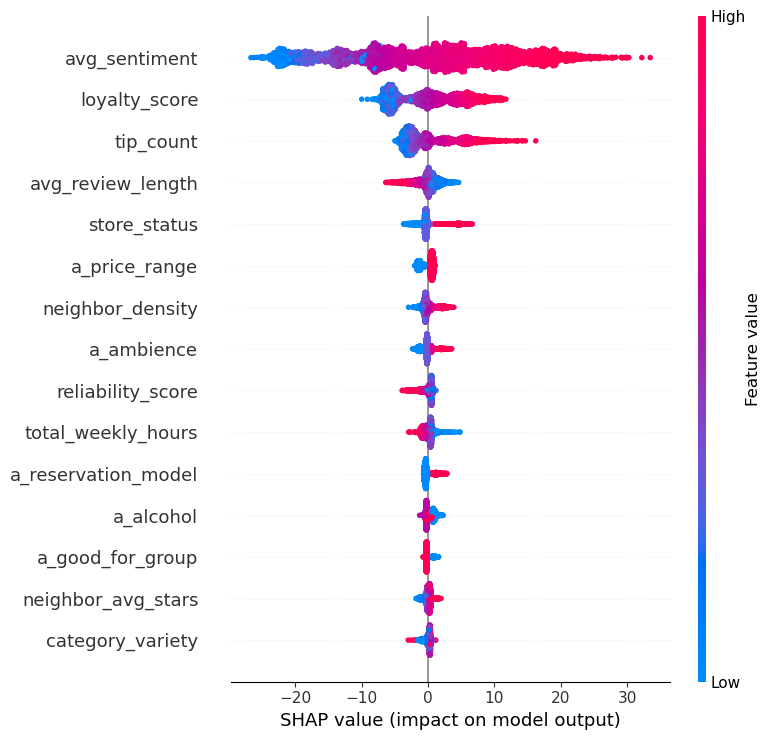

In [43]:
# 샵밸류 (cat)

# SHAP for Cat Boost
explainer = shap.TreeExplainer(final_cat)
shap_values = explainer.shap_values(X_test_enc)

# Summary plot
shap.summary_plot(shap_values, X_test_enc, max_display=15)